# Music Genre Classification

Using different algorithms to accurately classify music genres from audio samples

# USE KFOLD 
https://www.machinecurve.com/index.php/2020/02/18/how-to-use-k-fold-cross-validation-with-keras/

https://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/

# USE CALLBACKS
Can use earlystopping to stop based on parameters
checkpoints for finding best model based on validation accuracy -- can make own method to look for; best loss and best generalization so val_accuracy ~= train_accuracy

### Packages

In [1]:
import os
import cv2
from tensorflow import keras
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
import sklearn
import tensorflow as tf
import pandas as pd

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import PReLU
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#### Global Variables

In [3]:
GTZAN = {'nGenres': 10, 'genres': ['blues', 'classical', 'country', 'disco', 'hiphop', 
                                   'jazz', 'metal', 'pop', 'reggae', 'rock']}
EXTENDED_BALLROOM = {'nGenres': 9, 'genres': ['chacha', 'foxtrot', 'jive', 'quickstep', 'rumba',
                                              'samba', 'tango', 'viennesewaltz', 'waltz']}
FEATURES = ('stft', 'mfcc', 'melspectrogram', 'fouriertempogram')
RNG_STATE = 422
TEST_SIZE = 0.2
EPOCHS = 50
BATCH_SIZE = 64

# make model csv file to save stats
MODEL_COLS = ["Model Name", "Method", "Dataset", "Feature", "Split", "Test Accuracy", "Test Loss",
                                     "Train Accuracy", "Train Loss", "Best Epoch", "Validation Accuracy",
                                     "Validation Loss", "Training Accuracy", "Training Loss"]
MODEL_STATS = pd.DataFrame(columns = MODEL_COLS)
if not os.path.exists('models/models.csv'): # if not already made
    print("Created models.csv")
    MODEL_STATS.to_csv(r'models/models.csv', index = False)

### Helper Methods

In [4]:
def getFeatures(dataset, feature, split):
    # LOADING
    X = np.load(os.path.join(os.getcwd(), "datasets", dataset, "features", f"{feature}{split}-X.npy"))
    Y = np.load(os.path.join(os.getcwd(), "datasets", dataset, "features", f"{feature}{split}-Y.npy"))
    #SPLITTING
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = TEST_SIZE, random_state = RNG_STATE, 
                                                        stratify = Y)
    
    return (X_train, X_test, Y_train, Y_test)

In [5]:
def cnf_matrix():
    plt.figure(figsize=(11,11))
    cm = sklearn.metrics.confusion_matrix(np.argmax(Y_test, axis=-1), np.argmax(m.predict(X_test), axis=-1))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.xticks(list(range(10)), ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock'])
    plt.yticks(list(range(10)), ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock'])
    plt.title('Confusion matrix for DCNN model')
    plt.xlabel('Predicted genre')
    plt.ylabel('True genre')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.show()

In [71]:
def plot_graph(history, title, download = True):
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title(f'{title} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc = 'upper left')
    if download:
        plt.savefig(f'models/graphs/{name}-Accuracy.png')
    plt.show()
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{title} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc = 'upper left')
    if download:
        plt.savefig(f'models/graphs/{name}-Loss.png')
    plt.show()

In [7]:
def get_res(history, epoch):
    h = history.history
    train_acc = h['categorical_accuracy'][epoch - 1]
    val_acc = h['val_categorical_accuracy'][epoch - 1]
    train_loss = h['loss'][epoch - 1]
    val_loss = h['val_loss'][epoch - 1]
    #print(train_acc, val_acc, train_loss, val_loss)
    
    return train_acc, train_loss, val_acc, val_loss

# Processing

Librosa for feature extraction of audio files\
STFT | MFCC | Melspectrogram | Fourier Tempogram

GTZAN (10 Genres)\
Extended Ballroom (9 Genres - removed 4 for having less than 100 samples)

In [237]:
def process(dataset, feature, time_split, verbose = False, save = False):
    N_FFT = 2048
    HOP_LENGTH = 1024
    N_MELS = 64
    N_MFCC = 13
    
    processed = []
    processed_genres = []
    
    feature = feature.lower()
    aud_path = os.path.join(os.getcwd(), "datasets", dataset, "audio")
    if not os.path.exists(aud_path):
        print("Dataset not found:", aud_path)
        return
        
    features = ("stft", "melspectrogram", "mfcc", "fouriertempogram")
    TOTAL_GENRES = len(os.listdir(aud_path))

    if feature not in features:
        print(f"{feature} not available for extraction")
        return
    
    feat_path = os.path.join(os.getcwd(), "datasets", dataset, "features")
    os.path.isdir(feat_path) or os.makedirs(feat_path)
    
    currentGenre = 0
    for folder in os.listdir(aud_path):
        folder_path = os.path.join(aud_path, folder)
        for audio in os.listdir(folder_path):  
            audio_path = os.path.join(folder_path, audio)
            y, sr = librosa.load(audio_path) # can user offset and duration for 5 second intervals
            if feature == "stft":
                feat = np.abs(librosa.stft(y, hop_length = HOP_LENGTH, n_fft = N_FFT))
            elif feature == "mfcc":
                feat = librosa.feature.mfcc(y = y, sr = sr, hop_length = HOP_LENGTH, 
                                                      n_fft = N_FFT)
            elif feature == "melspectrogram":
                feat = librosa.feature.melspectrogram(y = y, sr = sr, n_mels = N_MELS, n_fft = N_FFT,
                                                     hop_length = HOP_LENGTH)
            elif feature == "fouriertempogram":
                oenv = librosa.onset.onset_strength(y = y, sr = sr, hop_length = HOP_LENGTH)
                feat = librosa.feature.fourier_tempogram(onset_envelope = oenv, sr = sr, hop_length = HOP_LENGTH)
                #feat = librosa.feature.tempogram(onset_envelope = oenv, sr = sr, hop_length = HOP_LENGTH)
            feat = librosa.power_to_db(feat ** 2) # feat ** 2 for amplitude to db
            #if len(feat[0]) != 647:
            #    print(len(feat[0]))
            #print(feat.shape)
            #print(feat[:2, :512].shape)
            #librosa.display.specshow(feat[:, :], sr=sr, hop_length = HOP_LENGTH, x_axis = 'time', y_axis = 'mel')
            #print(feat.shape)
            
            # max is (x, 647) or (x, 648) -- imma treat max as 640 -- can be //10,8,5,4,2 -> 3, 3.75, 6, 7.5, 15
            out = feat[:, :640]

            # split into segments -- 3, 3.75, 6, 7.5, 15 seconds
            out_split = np.hsplit(out, time_split)
            for split in out_split:
                #print(split.shape)
                processed.append(split)
                # one hot encoding
                processed_genres.append([1 if i == currentGenre else 0 for i in range(TOTAL_GENRES)])
                #librosa.display.specshow(split[:, :], sr=sr, hop_length = HOP_LENGTH, x_axis = 'time', y_axis = 'mel')
            #print(len(out_split))
            #librosa.display.specshow(out[:, :], sr=sr, hop_length = HOP_LENGTH)
        currentGenre += 1
        if verbose:
            print(folder, "complete;", feature, processed[0].shape)
    
    X = np.array(processed)
    Y = np.array(processed_genres)
    
    
    if save:
        #np.save(os.path.join(feat_path, f"{feature + str(time_split)}-X.npy"), X)
        #np.save(os.path.join(feat_path, f"{feature + str(time_split)}-Y.npy"), Y)
        pass
    
    return X, Y

### Run to extract features if have not done so already

Extracting features from Extended Ballroom taks a while, 10x+ longer than GTZAN

Processing GTZAN with total genres of 10
	melspectrogram with splits (1,) took 0.04217649999191053 seconds


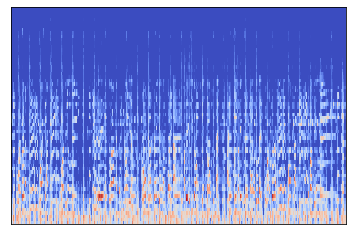

In [242]:
#features = ("stft", "melspectrogram", "mfcc", "fouriertempogram",)
features = ("melspectrogram",)
#datasets = ("GTZAN", "Extended Ballroom",)
datasets = ('GTZAN',)
splits = (10, 8, 5, 4, 2, 1)
splits = (1, )
for dataset in datasets:
    print("Processing", dataset, "with total genres of", 
              len(os.listdir(os.path.join(os.getcwd(), "datasets", dataset, "audio"))))
    for feature in features:
        start = time.perf_counter()
        for split in splits:
            process(dataset, feature, split, verbose = True, save = True)
        print(f"\t{feature} with splits", str(splits), "took", time.perf_counter() - start, "seconds")

### References

yang2020parallel
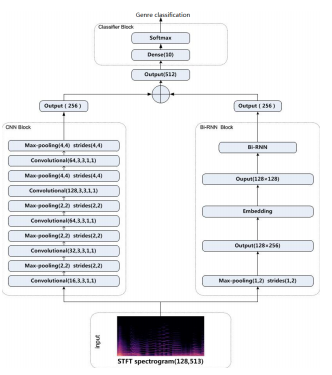

## CNN

Explain general structure of what i did

### STFT (1025, 640)

In [35]:
def conv_block(x, n_filters, kernel_size, conv_strides, pool_strides, pool_size):
    x = Conv2D(n_filters, kernel_size, strides = conv_strides, padding='same')(x)
    x = BatchNormalization()(x) # should do this
    x = Activation('relu')(x)
    
    # reduce overfitting by oversampling? extracts most prominent features
    x = MaxPooling2D(pool_size=pool_size, strides=pool_size)(x)
    x = Dropout(0.25)(x) # to reduce overfitting # shouldnt do this when its first level
    return x

In [36]:
def CNN(input_shape, num_genres, name):
    inpt = Input(shape=input_shape)
    
    x = conv_block(inpt, n_filters = 16, kernel_size = (3, 3), 
                   conv_strides = (1, 1), pool_strides = (2, 2), pool_size = (2, 2))
    
    x = conv_block(x, n_filters = 32, kernel_size = (3, 3), 
                   conv_strides = (1, 1), pool_strides = (2, 2), pool_size = (2, 2))
    
    x = conv_block(x, n_filters = 64, kernel_size = (3, 3), 
                   conv_strides = (1, 1), pool_strides = (2, 2), pool_size = (2, 2))
    
    x = conv_block(x, n_filters = 128, kernel_size = (3, 3), 
                   conv_strides = (1, 1), pool_strides = (4, 4), pool_size = (4, 4))
    
    x = conv_block(x, n_filters = 64, kernel_size = (3, 3), 
                   conv_strides = (1, 1), pool_strides = (2, 2), pool_size = (2, 2))
    
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu', 
              kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.25)(x)
    predictions = Dense(num_genres, 
                        activation='softmax', 
                        kernel_regularizer = tf.keras.regularizers.l2(0.02))(x)
    
    model = Model(inputs=inpt, outputs=predictions, name = name) # can add name
    return model

#### GTZAN

In [75]:
# Get Features
uid = np.random.randint(1, 10000) # 'unique' id
while sum([x.startswith(str(uid)) for x in os.listdir('models/')]) != 0: # if duplicate
    uid = np.random.randint(1, 10000)
split = 10
mod = 'CNN'
feat = 'STFT'
dat = 'GTZAN'
name = '_'.join([x.upper() for x in [str(uid), mod, feat,dat, str(split)]])
X_train, X_test, Y_train, Y_test = getFeatures(dat, feat, split)
#print(X_train.shape)
# Model
m = CNN(X_train.shape[1:] + (1,), 10, name)
opt = keras.optimizers.Adam(lr = 0.001)
m.compile(optimizer = opt, loss = "categorical_crossentropy", metrics = ['categorical_accuracy'])
m.summary()

Model: "594_CNN_STFT_GTZAN_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 1025, 64, 1)]     0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 1025, 64, 16)      160       
_________________________________________________________________
batch_normalization_35 (Batc (None, 1025, 64, 16)      64        
_________________________________________________________________
activation_35 (Activation)   (None, 1025, 64, 16)      0         
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 512, 32, 16)       0         
_________________________________________________________________
dropout_49 (Dropout)         (None, 512, 32, 16)       0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 512, 32, 

In [76]:
checkpoint_path = 'checkpoints/{val_loss:.2f}-{epoch:02d}.hdf5'
history = m.fit(X_train, Y_train, epochs = 100, batch_size = BATCH_SIZE, validation_split = 0.2,
     callbacks = [EarlyStopping(monitor = 'val_loss', mode = 'auto', patience = 15),
                 ModelCheckpoint(filepath = checkpoint_path, save_weights_only = False,
                                monitor = 'val_loss', mode = 'min',
                                save_best_only = True)])

Epoch 1/100
100/100 [==============================] - 243s 2s/step - loss: 6.9543 - categorical_accuracy: 0.2006 - val_loss: 4.7520 - val_categorical_accuracy: 0.2731
Epoch 2/100
100/100 [==============================] - 240s 2s/step - loss: 4.2141 - categorical_accuracy: 0.3641 - val_loss: 3.2429 - val_categorical_accuracy: 0.4244
Epoch 3/100
100/100 [==============================] - 242s 2s/step - loss: 2.8888 - categorical_accuracy: 0.4491 - val_loss: 2.5734 - val_categorical_accuracy: 0.3600
Epoch 4/100
100/100 [==============================] - 242s 2s/step - loss: 2.2273 - categorical_accuracy: 0.4926 - val_loss: 2.1730 - val_categorical_accuracy: 0.4137
Epoch 5/100
100/100 [==============================] - 242s 2s/step - loss: 1.8358 - categorical_accuracy: 0.5410 - val_loss: 1.8596 - val_categorical_accuracy: 0.4756
Epoch 6/100
100/100 [==============================] - 242s 2s/step - loss: 1.5894 - categorical_accuracy: 0.5693 - val_loss: 1.5655 - val_categorical_accuracy:

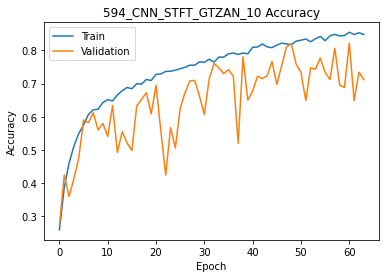

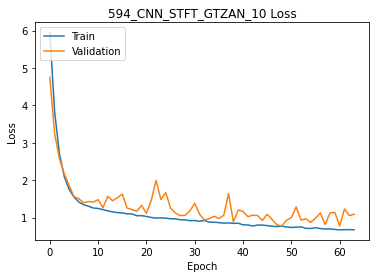

In [77]:
plot_graph(history, name) # should save the graphs as well

In [78]:
best_epoch = 49
train_acc, train_loss, val_acc, val_loss = get_res(history, best_epoch)
#print(train_acc, val_acc, train_loss, val_loss)

m.load_weights(f'checkpoints/{val_loss:.2f}-{best_epoch:02d}.hdf5') # gets the best model weights

In [79]:
train = m.evaluate(X_train, Y_train)
print("Loss:", train[0])
print("Train Accuracy:", train[1])

250/250 [==============================] - 39s 154ms/step - loss: 0.6409 - categorical_accuracy: 0.8789
Loss: 0.6409105658531189
Train Accuracy: 0.8788750171661377


In [80]:
test = m.evaluate(X_test, Y_test)
print("Loss:", test[0])
print("Test Accuracy:", test[1])

63/63 [==============================] - 10s 149ms/step - loss: 0.7763 - categorical_accuracy: 0.8250
Loss: 0.7762635946273804
Test Accuracy: 0.824999988079071


In [81]:
m.save(f'models/{name}.h5') # save model
# save stats of model
cur_mod_stats = pd.DataFrame([[name, mod, dat, feat, split, test[1], test[0], train[1], train[0],
                             best_epoch, val_acc, val_loss, train_acc, train_loss]], columns = MODEL_COLS)
cur_mod_stats.to_csv('models/models.csv', mode = 'a', header = False, index = False)

#### Extended Ballroom

Bro training takes so long for this... 1200s per epoch

In [118]:
# Get Features
uid = np.random.randint(1, 10000) # 'unique' id
while sum([x.startswith(str(uid)) for x in os.listdir('models/')]) != 0: # if duplicate
    uid = np.random.randint(1, 10000)
split =10
mod = 'CNN'
feat = 'STFT'
dat = 'ExtendedBallroom'
name = '_'.join([x.upper() for x in [str(uid), mod, feat,dat, str(split)]])
X_train, X_test, Y_train, Y_test = getFeatures("EXTENDED BALLROOM", feat, split)
# Model
m = CNN(X_train.shape[1:] + (1,), EXTENDED_BALLROOM['nGenres'], name)
opt = keras.optimizers.Adam(lr = 0.001)
m.compile(optimizer = opt, loss = "categorical_crossentropy", metrics = ['categorical_accuracy'])
m.summary()

Model: "6968_CNN_STFT_EXTENDEDBALLROOM_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 1025, 64, 1)]     0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 1025, 64, 16)      160       
_________________________________________________________________
batch_normalization_65 (Batc (None, 1025, 64, 16)      64        
_________________________________________________________________
activation_65 (Activation)   (None, 1025, 64, 16)      0         
_________________________________________________________________
max_pooling2d_65 (MaxPooling (None, 512, 32, 16)       0         
_________________________________________________________________
dropout_91 (Dropout)         (None, 512, 32, 16)       0         
_________________________________________________________________
conv2d_66 (Conv2D)           (Non

In [119]:
checkpoint_path = 'checkpoints/{val_loss:.2f}-{epoch:02d}.hdf5'
history = m.fit(X_train, Y_train, epochs = 100, batch_size = BATCH_SIZE, validation_split = 0.2,
     callbacks = [EarlyStopping(monitor = 'val_loss', mode = 'auto', patience = 15),
                 ModelCheckpoint(filepath = checkpoint_path, save_weights_only = False,
                                monitor = 'val_loss', mode = 'min',
                                save_best_only = True)])

Epoch 1/100
400/400 [==============================] - 1024s 3s/step - loss: 5.1641 - categorical_accuracy: 0.2600 - val_loss: 3.1425 - val_categorical_accuracy: 0.2311
Epoch 2/100
400/400 [==============================] - 1017s 3s/step - loss: 1.6388 - categorical_accuracy: 0.5430 - val_loss: 1.8515 - val_categorical_accuracy: 0.4618
Epoch 3/100
400/400 [==============================] - 1010s 3s/step - loss: 1.0749 - categorical_accuracy: 0.7041 - val_loss: 1.2034 - val_categorical_accuracy: 0.6356
Epoch 4/100
400/400 [==============================] - 1003s 3s/step - loss: 0.9294 - categorical_accuracy: 0.7494 - val_loss: 0.8039 - val_categorical_accuracy: 0.7888
Epoch 5/100
400/400 [==============================] - 1001s 3s/step - loss: 0.8404 - categorical_accuracy: 0.7744 - val_loss: 1.0328 - val_categorical_accuracy: 0.7044
Epoch 6/100
400/400 [==============================] - 1002s 3s/step - loss: 0.8064 - categorical_accuracy: 0.7875 - val_loss: 0.8423 - val_categorical_acc

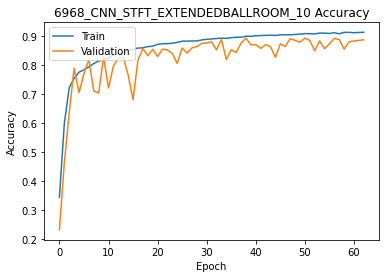

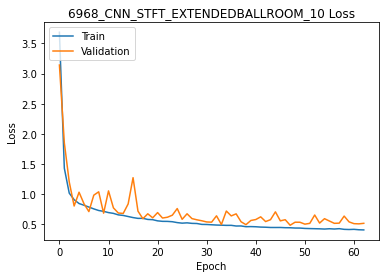

In [120]:
plot_graph(history, name) 

In [121]:
best_epoch = 48
train_acc, train_loss, val_acc, val_loss = get_res(history, best_epoch)
#print(train_acc, val_acc, train_loss, val_loss)

m.load_weights(f'checkpoints/{val_loss:.2f}-{best_epoch:02d}.hdf5') # gets the best model weights

In [122]:
train = m.evaluate(X_train, Y_train)
print("Loss:", train[0])
print("Train Accuracy:", train[1])

998/998 [==============================] - 181s 181ms/step - loss: 0.3530 - categorical_accuracy: 0.9345
Loss: 0.35299474000930786
Train Accuracy: 0.9344626665115356


In [123]:
test = m.evaluate(X_test, Y_test)
print("Loss:", test[0])
print("Test Accuracy:", test[1])

250/250 [==============================] - 46s 183ms/step - loss: 0.4628 - categorical_accuracy: 0.8947
Loss: 0.4628380835056305
Test Accuracy: 0.8946643471717834


In [124]:
m.save(f'models/{name}.h5') # save model
# save stats of model
cur_mod_stats = pd.DataFrame([[name, mod, dat, feat, split, test[1], test[0], train[1], train[0],
                             best_epoch, val_acc, val_loss, train_acc, train_loss]], columns = MODEL_COLS)
cur_mod_stats.to_csv('models/models.csv', mode = 'a', header = False, index = False)

### MFCC (20, 640)

In [8]:
def MFCC_block(x, n_filters, kernel_size, conv_strides, pool_strides, pool_size, dropout = None):
    x = Conv2D(n_filters, kernel_size, strides = conv_strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # reduce overfitting by oversampling? extracts most prominent features
    x = MaxPooling2D(pool_size=pool_size, strides=pool_size)(x)
    if dropout:
        x = Dropout(dropout)(x) # to reduce overfitting # shouldnt do this when its first level
    return x

In [9]:
def MFCC_CNN(input_shape, num_genres, name):
    inpt = Input(shape=input_shape)
    
    x = MFCC_block(inpt, n_filters = 32, kernel_size = (3, 3), 
                   conv_strides = (1, 1), pool_strides = (2, 2), pool_size = (2, 2), dropout = 0.25)
    
    x = MFCC_block(x, n_filters = 64, kernel_size = (3, 3), 
                   conv_strides = (1, 1), pool_strides = (2, 2), pool_size = (2, 2), dropout = 0.25)
    
    x = MFCC_block(x, n_filters = 128, kernel_size = (3, 3), 
                   conv_strides = (1, 1), pool_strides = (2, 2), pool_size = (2, 2), dropout = 0.25)
    
    x = MFCC_block(x, n_filters = 64, kernel_size = (3, 3), 
                   conv_strides = (1, 1), pool_strides = (2, 2), pool_size = (2, 2), dropout = 0.25)
    
    x = Flatten()(x)
    x = Dropout(0.25)(x)
    x = Dense(256, activation='relu', 
              kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.25)(x)
    predictions = Dense(num_genres, 
                        activation='softmax', 
                        kernel_regularizer = tf.keras.regularizers.l2(0.02))(x)
    
    model = Model(inputs=inpt, outputs=predictions, name = name)
    return model

#### GTZAN

Model: "5027_CNN_MFCC_GTZAN_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 20, 64, 1)]       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 20, 64, 32)        320       
_________________________________________________________________
batch_normalization_20 (Batc (None, 20, 64, 32)        128       
_________________________________________________________________
activation_20 (Activation)   (None, 20, 64, 32)        0         
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 10, 32, 32)        0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 10, 32, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 10, 32, 

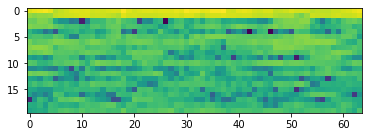

In [45]:
# Get Features
uid = np.random.randint(1, 10000) # 'unique' id
while sum([x.startswith(str(uid)) for x in os.listdir('models/')]) != 0: # if duplicate
    uid = np.random.randint(1, 10000)
split = 10
mod = 'CNN'
feat = 'MFCC'
dat = 'GTZAN'
name = '_'.join([x.upper() for x in [str(uid), mod, feat,dat, str(split)]])
X_train, X_test, Y_train, Y_test = getFeatures(dat, feat, split)
#print(X_train.shape)
plt.imshow(X_train[1])
# Model
m = MFCC_CNN(X_train.shape[1:] + (1,), 10, name)
opt = keras.optimizers.Adam(lr = 0.001)
m.compile(optimizer = opt, loss = "categorical_crossentropy", metrics = ['categorical_accuracy'])
m.summary()

In [46]:
checkpoint_path = 'checkpoints/{val_loss:.2f}-{epoch:02d}.hdf5'
history = m.fit(X_train, Y_train, epochs = 100, batch_size = BATCH_SIZE, validation_split = 0.2,
     callbacks = [EarlyStopping(monitor = 'val_loss', mode = 'auto', patience = 15),
                 ModelCheckpoint(filepath = checkpoint_path, save_weights_only = False,
                                monitor = 'val_loss', mode = 'min',
                                save_best_only = True)])

Epoch 1/100
100/100 [==============================] - 9s 81ms/step - loss: 5.2634 - categorical_accuracy: 0.1583 - val_loss: 6.8743 - val_categorical_accuracy: 0.0869
Epoch 2/100
100/100 [==============================] - 8s 80ms/step - loss: 3.4610 - categorical_accuracy: 0.3194 - val_loss: 4.5137 - val_categorical_accuracy: 0.1231
Epoch 3/100
100/100 [==============================] - 8s 79ms/step - loss: 2.5701 - categorical_accuracy: 0.3965 - val_loss: 2.2854 - val_categorical_accuracy: 0.3750
Epoch 4/100
100/100 [==============================] - 8s 79ms/step - loss: 2.1054 - categorical_accuracy: 0.4299 - val_loss: 2.0151 - val_categorical_accuracy: 0.3875
Epoch 5/100
100/100 [==============================] - 8s 78ms/step - loss: 1.8277 - categorical_accuracy: 0.4531 - val_loss: 1.7973 - val_categorical_accuracy: 0.4294
Epoch 6/100
100/100 [==============================] - 8s 78ms/step - loss: 1.6596 - categorical_accuracy: 0.4788 - val_loss: 1.8002 - val_categorical_accuracy:

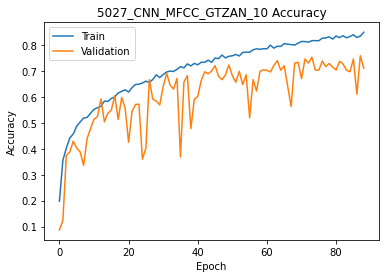

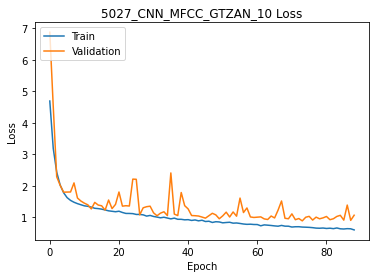

In [47]:
plot_graph(history, name)

In [48]:
best_epoch = 74
train_acc, train_loss, val_acc, val_loss = get_res(history, best_epoch)
#print(train_acc, val_acc, train_loss, val_loss)

m.load_weights(f'checkpoints/{val_loss:.2f}-{best_epoch:02d}.hdf5') # gets the best model weights

In [49]:
train = m.evaluate(X_train, Y_train)
print("Loss:", train[0])
print("Train Accuracy:", train[1])

250/250 [==============================] - 2s 9ms/step - loss: 0.4913 - categorical_accuracy: 0.9100
Loss: 0.4912721812725067
Train Accuracy: 0.9100000262260437


In [50]:
test = m.evaluate(X_test, Y_test)
#print(X_test.shape)
print("Loss:", test[0])
print("Test Accuracy:", test[1])

63/63 [==============================] - 1s 9ms/step - loss: 0.8779 - categorical_accuracy: 0.7590
Loss: 0.8778737187385559
Test Accuracy: 0.7590000033378601


In [51]:
m.save(f'models/{name}.h5') # save model
# save stats of model
cur_mod_stats = pd.DataFrame([[name, mod, dat, feat, split, test[1], test[0], train[1], train[0],
                             best_epoch, val_acc, val_loss, train_acc, train_loss]], columns = MODEL_COLS)
cur_mod_stats.to_csv('models/models.csv', mode = 'a', header = False, index = False)

#### Extended Ballroom

Model: "8789_CNN_MFCC_EXTENDEDBALLROOM_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 20, 64, 1)]       0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 20, 64, 32)        320       
_________________________________________________________________
batch_normalization_44 (Batc (None, 20, 64, 32)        128       
_________________________________________________________________
activation_44 (Activation)   (None, 20, 64, 32)        0         
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 10, 32, 32)        0         
_________________________________________________________________
dropout_66 (Dropout)         (None, 10, 32, 32)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (Non

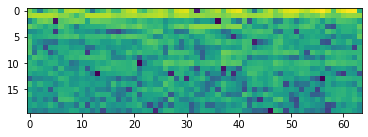

In [87]:
# Get Features
uid = np.random.randint(1, 10000) # 'unique' id
while sum([x.startswith(str(uid)) for x in os.listdir('models/')]) != 0: # if duplicate
    uid = np.random.randint(1, 10000)
split = 10
mod = 'CNN'
feat = 'MFCC'
dat = 'ExtendedBallroom'
name = '_'.join([x.upper() for x in [str(uid), mod, feat,dat, str(split)]])
X_train, X_test, Y_train, Y_test = getFeatures("EXTENDED BALLROOM", "mfcc", split)
#print(X_train.shape)
plt.imshow(X_train[1])
# Model
m = MFCC_CNN(X_train.shape[1:] + (1,), EXTENDED_BALLROOM['nGenres'], name)
opt = keras.optimizers.Adam(lr = 0.001)
m.compile(optimizer = opt, loss = "categorical_crossentropy", metrics = ['categorical_accuracy'])
m.summary()

In [88]:
checkpoint_path = 'checkpoints/{val_loss:.2f}-{epoch:02d}.hdf5'
history = m.fit(X_train, Y_train, epochs = 100, batch_size = BATCH_SIZE, validation_split = 0.2,
     callbacks = [EarlyStopping(monitor = 'val_loss', mode = 'auto', patience = 15),
                 ModelCheckpoint(filepath = checkpoint_path, save_weights_only = False,
                                monitor = 'val_loss', mode = 'min',
                                save_best_only = True)])

Epoch 1/100
400/400 [==============================] - 33s 81ms/step - loss: 4.1491 - categorical_accuracy: 0.2125 - val_loss: 2.1803 - val_categorical_accuracy: 0.2722
Epoch 2/100
400/400 [==============================] - 32s 80ms/step - loss: 1.9553 - categorical_accuracy: 0.3191 - val_loss: 1.7860 - val_categorical_accuracy: 0.3333
Epoch 3/100
400/400 [==============================] - 32s 80ms/step - loss: 1.7460 - categorical_accuracy: 0.3461 - val_loss: 1.8352 - val_categorical_accuracy: 0.3071
Epoch 4/100
400/400 [==============================] - 32s 80ms/step - loss: 1.7044 - categorical_accuracy: 0.3584 - val_loss: 1.7376 - val_categorical_accuracy: 0.3439
Epoch 5/100
400/400 [==============================] - 32s 80ms/step - loss: 1.6678 - categorical_accuracy: 0.3835 - val_loss: 2.0169 - val_categorical_accuracy: 0.2793
Epoch 6/100
400/400 [==============================] - 32s 80ms/step - loss: 1.5990 - categorical_accuracy: 0.4242 - val_loss: 1.7484 - val_categorical_acc

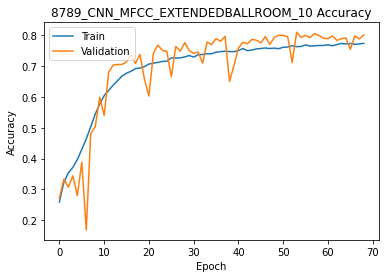

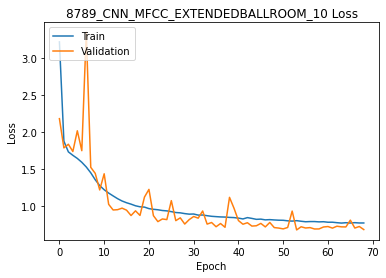

In [89]:
plot_graph(history, name)

In [90]:
best_epoch = 54
train_acc, train_loss, val_acc, val_loss = get_res(history, best_epoch)
#print(train_acc, val_acc, train_loss, val_loss)

m.load_weights(f'checkpoints/{val_loss:.2f}-{best_epoch:02d}.hdf5') # gets the best model weights

In [91]:
train = m.evaluate(X_train, Y_train)
print("Loss:", train[0])
print("Train Accuracy:", train[1])

998/998 [==============================] - 9s 9ms/step - loss: 0.5662 - categorical_accuracy: 0.8530
Loss: 0.566166877746582
Train Accuracy: 0.8529872298240662


In [92]:
test = m.evaluate(X_test, Y_test)
#print(X_test.shape)
print("Loss:", test[0])
print("Test Accuracy:", test[1])

250/250 [==============================] - 2s 9ms/step - loss: 0.6821 - categorical_accuracy: 0.8054
Loss: 0.6821264624595642
Test Accuracy: 0.805360734462738


In [93]:
m.save(f'models/{name}.h5') # save model
# save stats of model
cur_mod_stats = pd.DataFrame([[name, mod, dat, feat, split, test[1], test[0], train[1], train[0],
                             best_epoch, val_acc, val_loss, train_acc, train_loss]], columns = MODEL_COLS)
cur_mod_stats.to_csv('models/models.csv', mode = 'a', header = False, index = False)

### Melspectrogram (64, 640)

In [8]:
def mel_block(x, n_filters, kernel_size, conv_strides, pool_strides, pool_size):
    x = Conv2D(n_filters, kernel_size, strides = conv_strides, padding='same')(x)
    #x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # reduce overfitting by oversampling? extracts most prominent features
    x = MaxPooling2D(pool_size=pool_size, strides=pool_size)(x)
    x = Dropout(0.25)(x) # to reduce overfitting # shouldnt do this when its first level
    return x

In [9]:
def MEL_CNN(input_shape, num_genres, name):
    inpt = Input(shape=input_shape)
    
    x = mel_block(inpt, n_filters = 16, kernel_size = (3, 3), 
                   conv_strides = (1, 1), pool_strides = (2, 2), pool_size = (2, 2))
    
    x = mel_block(x, n_filters = 32, kernel_size = (3, 3), 
                   conv_strides = (1, 1), pool_strides = (2, 2), pool_size = (2, 2))
    
    x = mel_block(x, n_filters = 64, kernel_size = (3, 3), 
                   conv_strides = (1, 1), pool_strides = (2, 2), pool_size = (2, 2))
    
    x = mel_block(x, n_filters = 128, kernel_size = (3, 3), 
                   conv_strides = (1, 1), pool_strides = (4, 4), pool_size = (4, 4))
    
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu', 
              kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.25)(x)
    
    predictions = Dense(num_genres, 
                        activation='softmax', 
                        kernel_regularizer = tf.keras.regularizers.l2(0.02))(x)
    
    model = Model(inputs=inpt, outputs=predictions, name = name)
    return model

#### GTZAN

Model: "9658_CNN_MELSPECTROGRAM_GTZAN_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 16)        160       
_________________________________________________________________
activation (Activation)      (None, 64, 64, 16)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
activation_1 (Activation)    (None

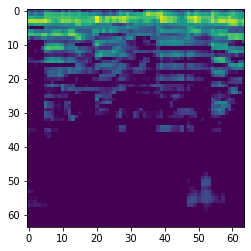

In [12]:
# Get Features
uid = np.random.randint(1, 10000) # 'unique' id
while sum([x.startswith(str(uid)) for x in os.listdir('models/')]) != 0: # if duplicate
    uid = np.random.randint(1, 10000)
split = 10
mod = 'CNN'
feat = 'MELSPECTROGRAM'
dat = 'GTZAN'
name = '_'.join([x.upper() for x in [str(uid), mod, feat,dat, str(split)]])
X_train, X_test, Y_train, Y_test = getFeatures(dat, feat, split)
#print(X_train.shape)
plt.imshow(X_train[1])
# Model
m = MEL_CNN(X_train.shape[1:] + (1,), 10, name)
opt = keras.optimizers.Adam(lr = 0.001)
m.compile(optimizer = opt, loss = "categorical_crossentropy", metrics = ['categorical_accuracy'])
m.summary()

In [13]:
checkpoint_path = 'checkpoints/{val_loss:.2f}-{epoch:02d}.hdf5'
history = m.fit(X_train, Y_train, epochs = 100, batch_size = BATCH_SIZE, validation_split = 0.2,
     callbacks = [EarlyStopping(monitor = 'val_loss', mode = 'auto', patience = 15),
                 ModelCheckpoint(filepath = checkpoint_path, save_weights_only = False,
                                monitor = 'val_loss', mode = 'min',
                                save_best_only = True)])

Epoch 1/100
100/100 [==============================] - 8s 77ms/step - loss: 7.9190 - categorical_accuracy: 0.1260 - val_loss: 5.0874 - val_categorical_accuracy: 0.1912
Epoch 2/100
100/100 [==============================] - 7s 68ms/step - loss: 4.6946 - categorical_accuracy: 0.2326 - val_loss: 4.0544 - val_categorical_accuracy: 0.3119
Epoch 3/100
100/100 [==============================] - 7s 70ms/step - loss: 3.6926 - categorical_accuracy: 0.3194 - val_loss: 3.2036 - val_categorical_accuracy: 0.3850
Epoch 4/100
100/100 [==============================] - 7s 71ms/step - loss: 2.9837 - categorical_accuracy: 0.3882 - val_loss: 2.8590 - val_categorical_accuracy: 0.3063
Epoch 5/100
100/100 [==============================] - 7s 69ms/step - loss: 2.4886 - categorical_accuracy: 0.4289 - val_loss: 2.4329 - val_categorical_accuracy: 0.3688
Epoch 6/100
100/100 [==============================] - 7s 68ms/step - loss: 2.1330 - categorical_accuracy: 0.4816 - val_loss: 2.0787 - val_categorical_accuracy:

100/100 [==============================] - 7s 69ms/step - loss: 0.9401 - categorical_accuracy: 0.7417 - val_loss: 0.9002 - val_categorical_accuracy: 0.7588
Epoch 50/100
100/100 [==============================] - 7s 68ms/step - loss: 0.9593 - categorical_accuracy: 0.7306 - val_loss: 0.8163 - val_categorical_accuracy: 0.7875
Epoch 51/100
100/100 [==============================] - 7s 71ms/step - loss: 0.9311 - categorical_accuracy: 0.7424 - val_loss: 0.8171 - val_categorical_accuracy: 0.8012
Epoch 52/100
100/100 [==============================] - 7s 71ms/step - loss: 0.8814 - categorical_accuracy: 0.7616 - val_loss: 0.7975 - val_categorical_accuracy: 0.7944
Epoch 53/100
100/100 [==============================] - 7s 75ms/step - loss: 0.9029 - categorical_accuracy: 0.7404 - val_loss: 0.8165 - val_categorical_accuracy: 0.8044
Epoch 54/100
100/100 [==============================] - 7s 72ms/step - loss: 0.8949 - categorical_accuracy: 0.7498 - val_loss: 0.8020 - val_categorical_accuracy: 0.7969

100/100 [==============================] - 7s 68ms/step - loss: 0.8060 - categorical_accuracy: 0.7905 - val_loss: 0.7195 - val_categorical_accuracy: 0.8044
Epoch 98/100
100/100 [==============================] - 7s 68ms/step - loss: 0.7658 - categorical_accuracy: 0.7990 - val_loss: 0.6814 - val_categorical_accuracy: 0.8313
Epoch 99/100
100/100 [==============================] - 7s 68ms/step - loss: 0.7716 - categorical_accuracy: 0.8018 - val_loss: 0.6800 - val_categorical_accuracy: 0.8431
Epoch 100/100
100/100 [==============================] - 7s 69ms/step - loss: 0.7479 - categorical_accuracy: 0.7996 - val_loss: 0.7196 - val_categorical_accuracy: 0.8238


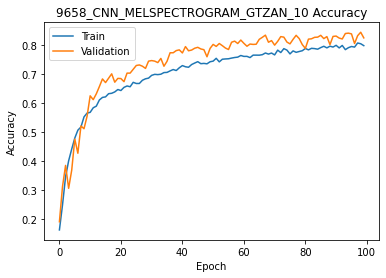

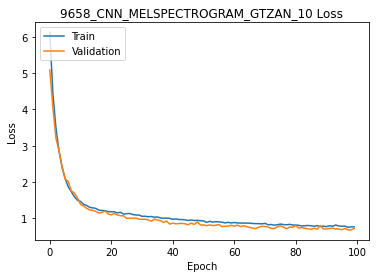

In [14]:
plot_graph(history, name)

In [15]:
best_epoch = 98
train_acc, train_loss, val_acc, val_loss = get_res(history, best_epoch)
#print(train_acc, val_acc, train_loss, val_loss)

m.load_weights(f'checkpoints/{val_loss:.2f}-{best_epoch:02d}.hdf5') # gets the best model weights

In [16]:
train = m.evaluate(X_train, Y_train)
print("Loss:", train[0])
print("Train Accuracy:", train[1])

250/250 [==============================] - 2s 9ms/step - loss: 0.5251 - categorical_accuracy: 0.9035
Loss: 0.52506422996521
Train Accuracy: 0.9035000205039978


In [17]:
test = m.evaluate(X_test, Y_test)
print(X_test.shape)
print("Loss:", test[0])
print("Test Accuracy:", test[1])

63/63 [==============================] - 1s 10ms/step - loss: 0.6946 - categorical_accuracy: 0.8330
(2000, 64, 64)
Loss: 0.6946128606796265
Test Accuracy: 0.8330000042915344


In [18]:
m.save(f'models/{name}.h5') # save model
# save stats of model
cur_mod_stats = pd.DataFrame([[name, mod, dat, feat, split, test[1], test[0], train[1], train[0],
                             best_epoch, val_acc, val_loss, train_acc, train_loss]], columns = MODEL_COLS)
cur_mod_stats.to_csv('models/models.csv', mode = 'a', header = False, index = False)

#### Extended Ballroom

(31936, 64, 64)
Model: "9243_CNN_MELSPECTROGRAM_EXTENDEDBALLROOM_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 64, 64, 16)        160       
_________________________________________________________________
activation_12 (Activation)   (None, 64, 64, 16)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 32)        4640      
_________________________________________________________________
activat

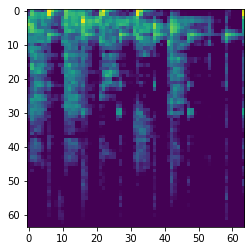

In [31]:
# Get Features
uid = np.random.randint(1, 10000) # 'unique' id
while sum([x.startswith(str(uid)) for x in os.listdir('models/')]) != 0: # if duplicate
    uid = np.random.randint(1, 10000)
split = 10
mod = 'CNN'
feat = 'MELSPECTROGRAM'
dat = 'ExtendedBallroom'
name = '_'.join([x.upper() for x in [str(uid), mod, feat,dat, str(split)]])
X_train, X_test, Y_train, Y_test = getFeatures("Extended Ballroom", feat, split)
print(X_train.shape)
plt.imshow(X_train[1])
# Model
m = MEL_CNN(X_train.shape[1:] + (1,), EXTENDED_BALLROOM['nGenres'], name)
opt = keras.optimizers.Adam(lr = 0.001)
m.compile(optimizer = opt, loss = "categorical_crossentropy", metrics = ['categorical_accuracy'])
m.summary()

In [32]:
checkpoint_path = 'checkpoints/{val_loss:.2f}-{epoch:02d}.hdf5'
history = m.fit(X_train, Y_train, epochs = 100, batch_size = BATCH_SIZE, validation_split = 0.2,
     callbacks = [EarlyStopping(monitor = 'val_loss', mode = 'auto', patience = 15),
                 ModelCheckpoint(filepath = checkpoint_path, save_weights_only = False,
                                monitor = 'val_loss', mode = 'min',
                                save_best_only = True)])

Epoch 1/100
400/400 [==============================] - 30s 72ms/step - loss: 5.5513 - categorical_accuracy: 0.1783 - val_loss: 2.6777 - val_categorical_accuracy: 0.3073
Epoch 2/100
400/400 [==============================] - 28s 71ms/step - loss: 2.3837 - categorical_accuracy: 0.3148 - val_loss: 1.9566 - val_categorical_accuracy: 0.3735
Epoch 3/100
400/400 [==============================] - 28s 71ms/step - loss: 1.8175 - categorical_accuracy: 0.3784 - val_loss: 1.7617 - val_categorical_accuracy: 0.4065
Epoch 4/100
400/400 [==============================] - 28s 71ms/step - loss: 1.6488 - categorical_accuracy: 0.4348 - val_loss: 1.4712 - val_categorical_accuracy: 0.5343
Epoch 5/100
400/400 [==============================] - 28s 70ms/step - loss: 1.4777 - categorical_accuracy: 0.5048 - val_loss: 1.2827 - val_categorical_accuracy: 0.6168
Epoch 6/100
400/400 [==============================] - 28s 71ms/step - loss: 1.3830 - categorical_accuracy: 0.5552 - val_loss: 1.2264 - val_categorical_acc

400/400 [==============================] - 28s 71ms/step - loss: 0.7668 - categorical_accuracy: 0.7861 - val_loss: 0.5990 - val_categorical_accuracy: 0.8518
Epoch 50/100
400/400 [==============================] - 28s 71ms/step - loss: 0.7507 - categorical_accuracy: 0.7975 - val_loss: 0.5968 - val_categorical_accuracy: 0.8460
Epoch 51/100
400/400 [==============================] - 29s 74ms/step - loss: 0.7420 - categorical_accuracy: 0.7962 - val_loss: 0.6073 - val_categorical_accuracy: 0.8427
Epoch 52/100
400/400 [==============================] - 29s 74ms/step - loss: 0.7484 - categorical_accuracy: 0.7922 - val_loss: 0.6007 - val_categorical_accuracy: 0.8428
Epoch 53/100
400/400 [==============================] - 29s 73ms/step - loss: 0.7490 - categorical_accuracy: 0.7907 - val_loss: 0.5867 - val_categorical_accuracy: 0.8469
Epoch 54/100
400/400 [==============================] - 29s 73ms/step - loss: 0.7589 - categorical_accuracy: 0.7881 - val_loss: 0.5837 - val_categorical_accuracy: 

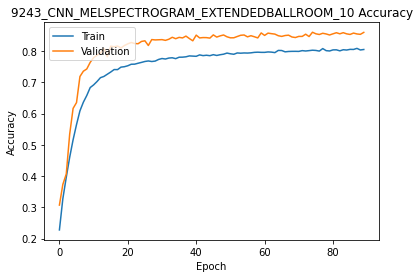

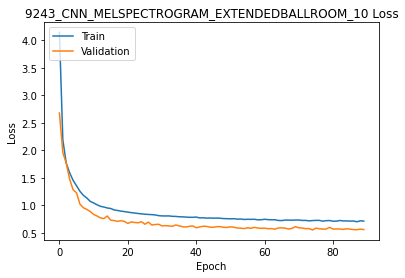

In [33]:
plot_graph(history, name)

In [34]:
best_epoch = 75
train_acc, train_loss, val_acc, val_loss = get_res(history, best_epoch)
#print(train_acc, val_acc, train_loss, val_loss)

m.load_weights(f'checkpoints/{val_loss:.2f}-{best_epoch:02d}.hdf5') # gets the best model weights

In [35]:
train = m.evaluate(X_train, Y_train)
print("Loss:", train[0])
print("Train Accuracy:", train[1])

998/998 [==============================] - 10s 10ms/step - loss: 0.4859 - categorical_accuracy: 0.8831
Loss: 0.48590248823165894
Train Accuracy: 0.8830786347389221


In [36]:
test = m.evaluate(X_test, Y_test)
#print(X_test.shape)
print("Loss:", test[0])
print("Test Accuracy:", test[1])

250/250 [==============================] - 2s 10ms/step - loss: 0.5653 - categorical_accuracy: 0.8506
Loss: 0.5652881860733032
Test Accuracy: 0.8505761623382568


In [37]:
m.save(f'models/{name}.h5') # save model
# save stats of model
cur_mod_stats = pd.DataFrame([[name, mod, dat, feat, split, test[1], test[0], train[1], train[0],
                             best_epoch, val_acc, val_loss, train_acc, train_loss]], columns = MODEL_COLS)
cur_mod_stats.to_csv('models/models.csv', mode = 'a', header = False, index = False)

# Base Results

In the results below, Train Accuracy and Training Accuracy are different. Training Accuracy is the training accuracy from the resulting best epoch, while the Train Accuracy is basically the overall train accuracy of the model. 

In [111]:
MODELS_PATH = os.path.join(os.getcwd(), 'models', 'models.csv')
MODELS = pd.read_csv(MODELS_PATH).set_index("Model Name")
MODELS = MODELS.sort_values('Test Accuracy', ascending = False)
MODELS

,Method,Dataset,Feature,Split,Test Accuracy,Test Loss,Train Accuracy,Train Loss,Best Epoch,Validation Accuracy,Validation Loss,Training Accuracy,Training Loss
Model Name,,,,,,,,,,,,,
7655_CNN_STFT_EXTENDEDBALLROOM_1,CNN,ExtendedBallroom,STFT,1,0.926158,0.492275,0.958660,0.383785,65,0.924883,0.519129,0.940094,0.407142
5229_CNN_STFT_EXTENDEDBALLROOM_2,CNN,ExtendedBallroom,STFT,2,0.921728,0.482177,0.951307,0.384229,38,0.917058,0.478434,0.929340,0.423746
5273_CNN_MELSPECTROGRAM_EXTENDEDBALLROOM_1,CNN,ExtendedBallroom,MELSPECTROGRAM,1,0.914894,0.658619,0.976198,0.472831,99,0.917058,0.693581,0.942443,0.552301
5671_CNN_STFT_EXTENDEDBALLROOM_4,CNN,ExtendedBallroom,STFT,4,0.913901,0.452483,0.967042,0.299174,48,0.921722,0.423758,0.941384,0.360010
6520_CNN_MELSPECTROGRAM_EXTENDEDBALLROOM_2,CNN,ExtendedBallroom,MELSPECTROGRAM,2,0.911083,0.594169,0.944105,0.448364,51,0.918623,0.539827,0.892543,0.593064
7753_CNN_MELSPECTROGRAM_EXTENDEDBALLROOM_4,CNN,ExtendedBallroom,MELSPECTROGRAM,4,0.904822,0.517555,0.929936,0.414237,51,0.901761,0.486075,0.860750,0.602696
3375_CNN_STFT_EXTENDEDBALLROOM_5,CNN,ExtendedBallroom,STFT,5,0.903808,0.492371,0.945140,0.365856,39,0.910770,0.472410,0.926570,0.398633
7137_CNN_STFT_EXTENDEDBALLROOM_8,CNN,ExtendedBallroom,STFT,8,0.903413,0.473348,0.947432,0.318092,53,0.895499,0.492155,0.923329,0.383254
6968_CNN_STFT_EXTENDEDBALLROOM_10,CNN,ExtendedBallroom,STFT,10,0.894664,0.462838,0.934463,0.352995,48,0.891046,0.484993,0.903867,0.443369


In [116]:
for i in [1, 2, 4, 5, 8, 10]:
    test_a = MODELS[MODELS["Split"] == i]["Test Accuracy"].mean()
    train_a = MODELS[MODELS["Split"] == i]["Train Accuracy"].mean()
    v = MODELS[MODELS["Split"] == i]["Validation Loss"].mean()
    print(f"{i} split: Avg test Accuracy: {test_a:.3f}, Avg train Accuracy: {train_a:.3f}, Avg validation Loss: {v:.3f}")

1 split: Avg test Accuracy: 0.622, Avg train Accuracy: 0.700, Avg validation Loss: 1.513
2 split: Avg test Accuracy: 0.712, Avg train Accuracy: 0.805, Avg validation Loss: 1.303
4 split: Avg test Accuracy: 0.837, Avg train Accuracy: 0.899, Avg validation Loss: 0.701
5 split: Avg test Accuracy: 0.821, Avg train Accuracy: 0.895, Avg validation Loss: 0.663
8 split: Avg test Accuracy: 0.832, Avg train Accuracy: 0.893, Avg validation Loss: 0.684
10 split: Avg test Accuracy: 0.828, Avg train Accuracy: 0.894, Avg validation Loss: 0.676


### With the results above, I decided to use Split of 8s due to having more sample sizes which would lead to less overfitting and still having a high enough test accuracy.

# Parallel

CNN + RNN

CNN + CNN

One or multiple combinations, possibly with different inputs (features)

jeong2016learning
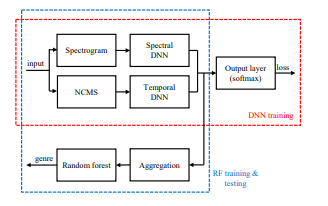

# Test

Use recent songs and test